# Task

Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.

Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
series = pd.read_csv("weekly-closings-of-the-dowjones-.csv")['Close']
series.head(3)

0    890.19
1    901.80
2    888.51
Name: Close, dtype: float64

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

# ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available',

aic: 1416.27670 | order: (2, 2, 3)
Results of Dickey-Fuller Test:
Test Statistic                -1.184571e+01
p-value                        7.408237e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


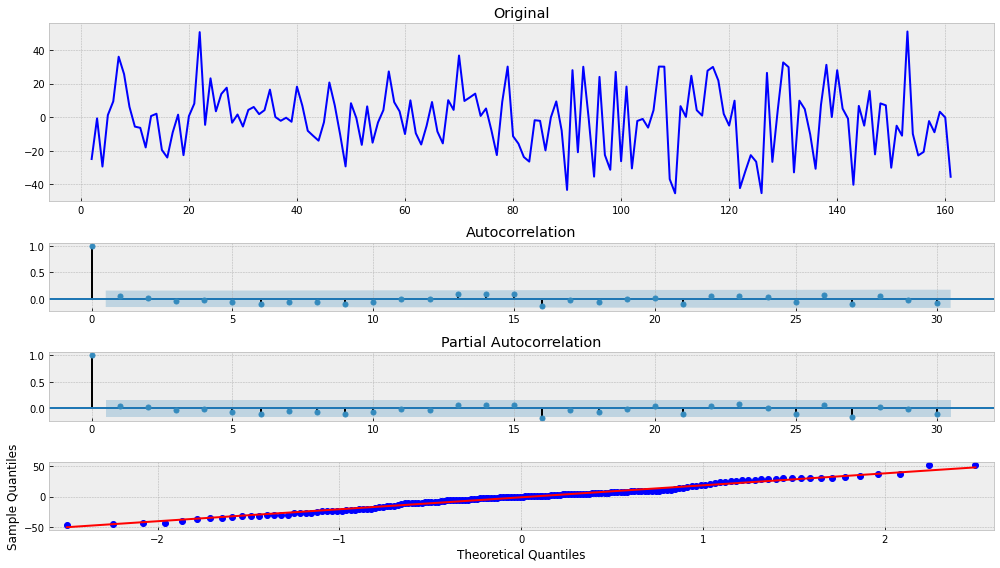

In [6]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

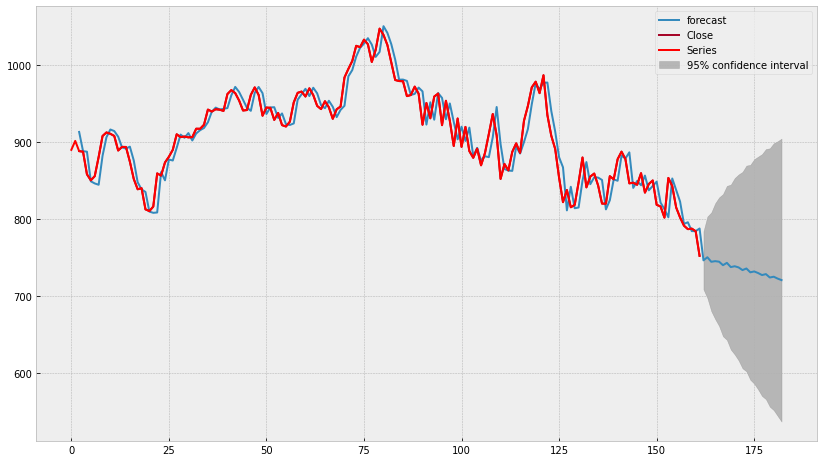

In [7]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(2, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

# Классический ML ARIMA

In [8]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['Close'].shift(i)
    data1 = data   
    data = data.dropna()
    data = data.reset_index(drop=True)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test, data1

In [9]:
X_train, X_test, y_train, y_test, data1 = prepareData(series, lag_start=5, lag_end=10, test_size=0.3)

In [10]:
data1

,Close,lag_5,lag_6,lag_7,lag_8,lag_9
0,890.19,NaN,NaN,NaN,NaN,NaN
1,901.80,NaN,NaN,NaN,NaN,NaN
2,888.51,NaN,NaN,NaN,NaN,NaN
3,887.78,NaN,NaN,NaN,NaN,NaN
4,858.43,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
157,791.77,802.17,816.65,818.84,850.44,845.90
158,787.23,853.72,802.17,816.65,818.84,850.44
159,787.94,843.09,853.72,802.17,816.65,818.84
160,784.57,815.39,843.09,853.72,802.17,816.65


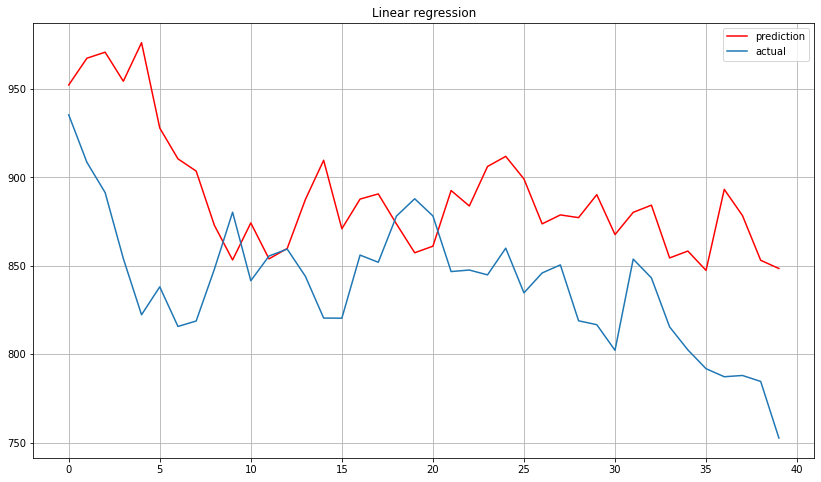

In [11]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
# plt.plot(series.values, label="data")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error

mean_squared_error(prediction, y_test.values)

3963.782329708031